In [1]:
import os
import glob
import zipfile
import functools
import re
import time
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import KFold, train_test_split
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
import pandas as pd
import imageio
from PIL import Image

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard

In [3]:
# Custom TensorBoard callback taken from https://stackoverflow.com/a/48393723

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)
        
    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        
        # Pass the non-validation logs to `TensorBoard.on_epoch_end`
        train_logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, train_logs)
        
        val_logs = {k.replace('val_', 'epoch_'): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

# Preprocessing pipeline

In [422]:
img_shape = [256, 256, 3]
batch_size = 4
epochs = 200
cv_splits = 1

DEBUG_OUTPUT = True

In [423]:
def _process_pathnames(fname, label_path):
  """Load the image pair from given paths"""
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  
  return img, label_img

### Data augmentation

In [434]:
def _augment_extract_training_patches(img, label_img, extract_patch_size, rotate):
  batch_size = tf.shape(img)[0]
  img_height = tf.shape(img)[1]
  img_width = tf.shape(img)[2]
    
  if extract_patch_size is not None:    
    patch_height = extract_patch_size[0]
    patch_width = extract_patch_size[1]
    patch_size = tf.cast([patch_height, patch_width], dtype=tf.int32)
        
    if rotate is not None:
      # Extract larger patches first, then rotate, then extract centered patch of correct size.
      rotate = float(rotate)
      angle = tf.random.uniform((), minval=-rotate, maxval=rotate)
      patch_height = tf.ceil(tf.abs(extract_patch_size[1] * tf.sin(angle)) + tf.abs(extract_patch_size[0] * tf.cos(angle)))
      patch_width = tf.ceil(tf.abs(extract_patch_size[1] * tf.cos(angle)) + tf.abs(extract_patch_size[0] * tf.sin(angle)))
      patch_size = tf.cast([patch_height, patch_width], dtype=tf.int32)
    
    half_patch_height = patch_height / 2
    offset_x = tf.random.uniform([batch_size], 
                                 minval=half_patch_height, 
                                 maxval=tf.cast(img_height, dtype=tf.float32) - half_patch_height)
    half_patch_width = patch_width / 2
    offset_y = tf.random.uniform([batch_size], 
                                 minval=half_patch_width, 
                                 maxval=tf.cast(img_width, dtype=tf.float32) - half_patch_width)
    offsets = tf.stack([offset_x, offset_y], axis=1)
    offsets = tf.cast(offsets, dtype=tf.float32)
  
    img = tf.image.extract_glimpse(img, patch_size, offsets, centered=False, normalized=False)
    label_img = tf.image.extract_glimpse(label_img, patch_size, offsets, centered=False, normalized=False)
  
  if rotate is not None:
    if angle is None:
      angle = float(rotate)
    img = tf.contrib.image.rotate(img, angle)
    label_img = tf.contrib.image.rotate(label_img, angle)
    
    if extract_patch_size is not None:
      # crop centered patches
      offsets = [half_patch_height, half_patch_width]
      offsets = tf.tile(tf.expand_dims(offsets, axis=0), [batch_size, 1])
      offsets = tf.cast(offsets, dtype=tf.float32)
      patch_size = tf.cast([extract_patch_size[0], extract_patch_size[1]], dtype=tf.int32)
      
      img = tf.image.extract_glimpse(img, patch_size, offsets, centered=False, normalized=False)
      label_img = tf.image.extract_glimpse(label_img, patch_size, offsets, centered=False, normalized=False)
      
  return img, label_img
  
def _augment_extract_validation_patches(img, label_img, extract_patch_size):
  patch_size = tf.cast([extract_patch_size[0], extract_patch_size[1]], dtype=tf.int32)
  batch_size = tf.shape(img)[0]
  img_height = tf.cast(tf.shape(img)[1], dtype=tf.float32)
  img_width = tf.cast(tf.shape(img)[2], dtype=tf.float32)
    
  half_height = tf.cast(extract_patch_size[0] / 2, dtype=tf.float32)
  xs = tf.linspace(half_height,
                   img_height - half_height, 
                   tf.cast(img_width / extract_patch_size[0], dtype=tf.int32))
  
  half_width = tf.cast(extract_patch_size[1] / 2, dtype=tf.float32)
  ys = tf.linspace(half_width, 
                   img_width - half_width, 
                   tf.cast(img_width / extract_patch_size[1], dtype=tf.int32))
  xx, yy = tf.meshgrid(xs, ys)
  xy = tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)
  xy = tf.cast(xy, dtype=tf.float32)
  
  num_patches = tf.shape(xy)[0]
  # new batch size is batch_size * num_patches
  batch_size = batch_size * num_patches
  
  img = tf.map_fn(lambda i: tf.image.extract_glimpse(
    tf.tile(tf.expand_dims(i, axis=0), [num_patches, 1, 1, 1]), 
    patch_size, xy, centered=False, normalized=False), img)
  # img has shape [batch_size, num_patches, height, width, num_channels]
  shape = tf.shape(img)
  img = tf.reshape(img, [batch_size, shape[2], shape[3], shape[4]])
  
  label_img = tf.map_fn(lambda i: tf.image.extract_glimpse(
    tf.tile(tf.expand_dims(i, axis=0), [num_patches, 1, 1, 1]),
    patch_size, xy, centered=False, normalized=False), label_img)
  # label_img has shape [batch_size, num_patches, height, width, num_channels]
  shape = tf.shape(label_img)
  label_img = tf.reshape(label_img, [batch_size, shape[2], shape[3], shape[4]])
    
  return img, label_img, batch_size

def _augment_flip(img, label_img, flip, is_training):
  batch_size = tf.shape(img)[0]
  
  if flip:
    if is_training:
      chance = tf.random.uniform([batch_size], minval=0.0, maxval=1.0)
      img = tf.map_fn(lambda x: tf.cond(x[1] > 0.5, lambda: tf.image.flip_left_right(x[0]), lambda: x[0]), 
                      (img, chance),
                      dtype=tf.float32)
      label_img = tf.map_fn(lambda x: tf.cond(x[1] > 0.5, lambda: tf.image.flip_left_right(x[0]), lambda: x[0]), 
                            (label_img, chance),
                            dtype=tf.float32)
    else:
      tmp = [img, tf.image.flip_left_right(img)]
      img = tf.concat(tmp, axis=0)
      tmp = [label_img, tf.image.flip_left_right(label_img)]
      label_img = tf.concat(tmp, axis=0)

  return img, label_img, batch_size

def _augment_rot90(img, label_img, rotate90, is_training):
  batch_size = tf.shape(img)[0]
  
  if rotate90:
    if is_training:
      rotate_count = tf.random_uniform([batch_size], minval=0, maxval=4, dtype=tf.int32)
      img = tf.map_fn(lambda x: tf.image.rot90(x[0], x[1]), (img, rotate_count), dtype=tf.float32)
      label_img = tf.map_fn(lambda x: tf.image.rot90(x[0], x[1]), (label_img, rotate_count), dtype=tf.float32)
      
    else:
      # Concatenate all four 90° rotations
      tmp = [tf.image.rot90(img, i) for i in range(4)]
      img = tf.concat(tmp, axis=0)
      tmp = [tf.image.rot90(label_img, i) for i in range(4)]
      label_img = tf.concat(tmp, axis=0)
      batch_size = tf.shape(img)[0]
      
  return img, label_img, batch_size

def _augment(img,
             label_img,
             extract_patch_size=None,
             rotate=None,
             resize=None,
             scale=1.0,
             hue_delta=None,
             contrast_factor_upper_bound = None,
             saturation_factor_upper_bound = None,
             flip=False,
             rotate90=False,
             is_training=False):
  """Apply data augmentation on batch"""
  
  batch_size = tf.shape(img)[0]
  
  # Scale
  img = tf.cast(img, tf.float32) * scale
  label_img = tf.cast(label_img, tf.float32) * scale
  
  if is_training:
    img, label_img = _augment_extract_training_patches(img, label_img, extract_patch_size, rotate)
  else:
    img, label_img, batch_size = _augment_extract_validation_patches(img, label_img, extract_patch_size)
    
  # Hue
  if hue_delta is not None:
    hue_delta = float(hue_delta)
    img = tf.image.random_hue(img, max_delta=hue_delta)

  # Contrast
  if contrast_factor_upper_bound is not None:
    upper_bound = float(contrast_factor_upper_bound)
    lower_bound = 1 / upper_bound
    img = tf.image.random_contrast(img, lower=lower_bound, upper=upper_bound)
    
  # Saturation
  if saturation_factor_upper_bound is not None:
    upper_bound = float(saturation_factor_upper_bound)
    lower_bound = 1 / upper_bound
    img = tf.image.random_saturation(img, lower=lower_bound, upper=upper_bound)
    
  # Ensure images are in [0, 1] range
  img = tf.minimum(tf.maximum(img, 0.0), 1.0)
  # Ensure pixels in label_img are either 0.0 or 1.0
  label_img = tf.cast(tf.cast(label_img > 0.5, dtype=tf.int32), dtype=tf.float32)
    
  # Random flip
  img, label_img, batch_size = _augment_flip(img, label_img, flip, is_training)
  # Random 90° rotations
  img, label_img, batch_size = _augment_rot90(img, label_img, rotate90, is_training)
  
  return img, label_img

In [435]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=6, 
                         batch_size=batch_size,
                         shuffle=True,
                         repeat=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  # It's necessary to repeat our data for all epochs
  if repeat:
    dataset = dataset.repeat()    
  
  dataset = dataset.prefetch(1)
  
  return dataset

# Define data sets

In [436]:
img_dir = '../competition-data/training/images'
label_dir = '../competition-data/training/groundtruth'
test_dir = '../competition-data/test'

In [437]:
train_filenames = os.listdir(img_dir)
x_train_filenames = np.array([os.path.join(img_dir, filename) for filename in train_filenames])
y_train_filenames = np.array([os.path.join(label_dir, filename) for filename in train_filenames])
test_filenames = os.listdir(test_dir)
x_test_filenames = np.array([os.path.join(test_dir, filename) for filename in test_filenames])

print("Number of training examples: {}".format(len(x_train_filenames)))
print("Number of test examples: {}".format(len(x_test_filenames)))

data_splits = []

if cv_splits > 1:
  kFold = KFold(n_splits=cv_splits, shuffle=True)
  data_splits = [(train, val) for train, val in kFold.split(x_train_filenames)]
else:
  train, val = train_test_split(range(len(x_train_filenames)), test_size=0.2)
  data_splits = [(np.array(train), np.array(val))]

Number of training examples: 100
Number of test examples: 94


### Debug Output: Image paths

In [438]:
if DEBUG_OUTPUT:
  print("Training images:\n", x_train_filenames[:5])
  print("Training labels:\n", y_train_filenames[:5])

Training images:
 ['../competition-data/training/images/satImage_045.png'
 '../competition-data/training/images/satImage_038.png'
 '../competition-data/training/images/satImage_054.png'
 '../competition-data/training/images/satImage_027.png'
 '../competition-data/training/images/satImage_008.png']
Training labels:
 ['../competition-data/training/groundtruth/satImage_045.png'
 '../competition-data/training/groundtruth/satImage_038.png'
 '../competition-data/training/groundtruth/satImage_054.png'
 '../competition-data/training/groundtruth/satImage_027.png'
 '../competition-data/training/groundtruth/satImage_008.png']


### Debug Output: x_train and y_train images

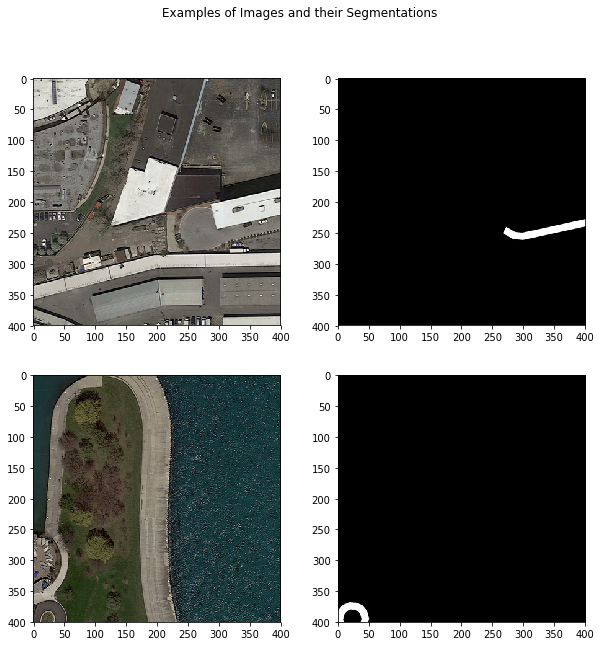

In [439]:
if DEBUG_OUTPUT:
  display_num = 2

  r_choices = np.random.choice(len(x_train_filenames), display_num)
  plt.figure(figsize=(10, 10))

  for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(mpimg.imread(x_pathname), cmap="gray")  
    plt.subplot(display_num, 2, i + 2)
    plt.imshow(mpimg.imread(y_pathname), cmap="gray")

  plt.suptitle("Examples of Images and their Segmentations")
  plt.show()

## Set up train and validation datasets
Note that we apply image augmentation to our training dataset but not our validation dataset. 

In [442]:
tr_cfg = {
  'is_training': True,
  # Extract patches of given size from image. Default: None
  'extract_patch_size': [img_shape[0], img_shape[1]],
  # Resize input images (and label images). Resize operation is applied after patch extraction. Default: None
  'resize': None,
  # Adjust value range by a scale factor. Default: 1.0
  'scale': 1 / 255.,
  # Adjust the hue of an RGB image by random factor choosen in range [-delta, delta]. Default: None
  'hue_delta': None,
  # Random contrast_factor choosen in range [1/upper_bound, upper_bound]. Default: None
  'contrast_factor_upper_bound': None,
  # Random saturation_factor choosen in range [1/upper_bound, upper_bound]. Default: None
  'saturation_factor_upper_bound': None,
  # Apply random left/right flip. Default: False
  'flip': True,
  # Apply rotation angle (in radians) choosen in range [-rotate, rotate]. Default: None
  'rotate': np.radians(45.0),
  # Apply random number of 90 degree rotations. Default: False
  'rotate90': True,
  
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [443]:
val_cfg = {
  'is_training': False,
  # Extract patches of the given size, covering the whole image.
  'extract_patch_size': [img_shape[0], img_shape[1]],
  'resize': None,
  'scale': 1 / 255.,
  # Also predict image on flipped versions. Increases effective batch_size by a factor of 2. Default: False
  'flip': True,
  # Also predict image on rotated versions. Increases effective batch_size by a factor of 4. Default: False
  'rotate90': True,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

### Debug Output: Preprocessing pipeline

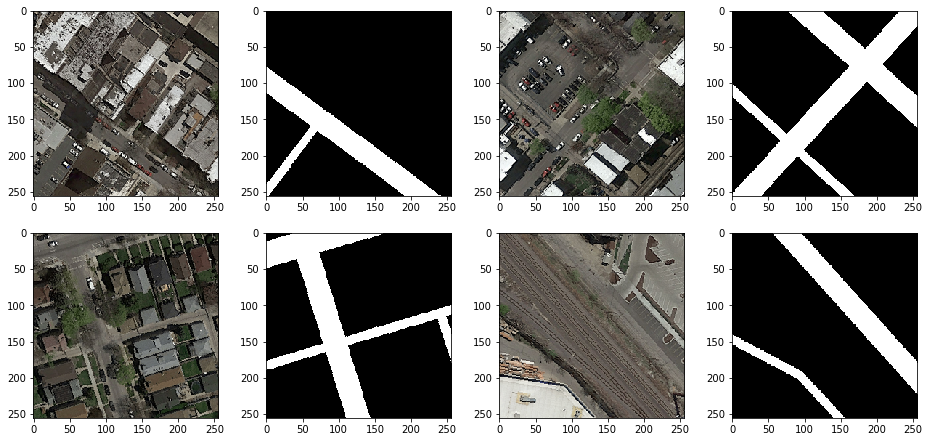

In [447]:
if DEBUG_OUTPUT:
  display_num = 4
  temp_ds = get_baseline_dataset(x_train_filenames, 
                                 y_train_filenames,
                                 preproc_fn=tr_preprocessing_fn,
                                 batch_size=1,
                                 shuffle=False)
  # Let's examine some of these augmented images
  data_aug_iter = temp_ds.make_one_shot_iterator()
  next_element = data_aug_iter.get_next()
  
  created_figure = False
  
  with tf.Session() as sess: 
    for i in range(display_num):
      batch_of_imgs, label = sess.run(next_element)
      
      if not created_figure:
        created_figure = True
        batch_size = len(batch_of_imgs)
        plt.figure(figsize=(16, 8*display_num*batch_size))
      
      for j in range(batch_size):
        plt.subplot(2 * display_num * batch_size, 4, 2 * batch_size * i + 2 * j + 1)
        plt.imshow(batch_of_imgs[j])
        plt.subplot(2 * display_num * batch_size, 4, 2 * batch_size * i + 2 * j + 2)
        plt.imshow(label[j, :, :, 0], cmap='gray')  
  plt.show()

## Define losses
Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced. 

We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly. 

In [407]:
def dice_coeff(y_true, y_pred):
  smooth = 1.0
  intersection = tf.reduce_sum(y_true * y_pred)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
  return score

def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

Here, we'll use a specialized loss function that combines binary cross entropy and our dice loss. This is based on [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). Try out your own custom losses to measure performance (e.g. bce + log(dice_loss), only bce, etc.)!

In [ ]:
def binary_crossentropy(y_true, y_pred):
  return losses.binary_crossentropy(y_true, y_pred)

In [ ]:
def root_mean_squared_error(y_true, y_pred):
  loss = tf.sqrt(losses.mean_squared_error(y_true, y_pred))
  return loss

In [ ]:
# implementation taken from https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
# 
def tversky_loss(beta=0.5):
  def loss(y_true, y_pred):
    numerator = tf.reduce_sum(y_true * y_pred)
    false_positives = (1.0 - y_true) * y_pred
    false_negatives = y_true * (1.0 - y_pred)
    denominator = y_true * y_pred + beta * false_positives + (1 - beta) * false_negatives

    return numerator / (tf.reduce_sum(denominator) + tf.keras.backend.epsilon())

  return loss

In [ ]:
def loss_fn(y_true, y_pred):
  # Flatten
  y_true = tf.reshape(y_true, [-1])
  y_pred = tf.reshape(y_pred, [-1])
  
  loss = binary_crossentropy(y_true, y_pred)
  #loss = dice_loss(y_true, y_pred)
  #loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  #loss = 1/24.0 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred) + root_mean_squared_error(y_true, y_pred) + tversky_loss(0.2)(y_true, y_pred)
  
  return loss

# Define our neural network architecture

In [ ]:
def conv_block(input_tensor, num_filters):
  layer = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  layer = layers.BatchNormalization()(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Conv2D(num_filters, (3, 3), padding='same')(layer)
  layer = layers.BatchNormalization()(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.1)(layer)
  return layer

def residual_block(input_tensor, num_filters, dilation_rate=1):
  # Shape of input_tensor: [batch_size, height, width, num_channels]
  _, _, _, num_channels = input_tensor.shape
  layer = input_tensor
  layer = layers.Conv2D(num_filters, (3, 3), padding='same', dilation_rate=1)(layer)
  layer = layers.Lambda(tf.contrib.layers.layer_norm)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Conv2D(num_filters, (3, 3), padding='same', dilation_rate=2)(layer)
  layer = layers.Lambda(tf.contrib.layers.layer_norm)(layer)
  
  # Apply projection if num_filters are not equal
  if num_filters != num_channels:
    input_tensor = layers.Conv2D(num_filters, (1, 1), padding='same')(input_tensor)  
  layer = layers.Add()([input_tensor, layer])
  
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.1)(layer)
  return layer

def residual_bottleneck_block(input_tensor, num_filters, dilation_rate=1):
  # Shape of input_tensor: [batch_size, height, width, num_channels]
  _, _, _, num_channels = input_tensor.shape
  layer = layers.Conv2D(num_filters, (1, 1), padding='same')(input_tensor)
  layer = layers.Lambda(tf.contrib.layers.layer_norm)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Conv2D(num_filters, (3, 3), padding='same', dilation_rate=dilation_rate)(layer)
  layer = layers.Lambda(tf.contrib.layers.layer_norm)(layer)
  
  # Apply final projection if num_filters are not equal
  if num_filters != num_channels:
    layer = layers.Conv2D(num_channels, (1, 1), padding='same')(layer)  
  layer = layers.Add()([input_tensor, layer])
  
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.1)(layer)
  return layer

def dilated_spatial_pyramid_pooling(input_tensor, num_filters, num_filters_out=256, dilation_rates=[1]):
  to_concat = []
  to_concat.append(layers.Conv2D(num_filters, (1, 1), padding='same')(input_tensor))
  for d in dilation_rates:
    to_concat.append(layers.Conv2D(num_filters, (3, 3), padding='same', dilation_rate=d)(input_tensor))  
  output = layers.Concatenate(axis=-1)(to_concat)
  output = layers.Conv2D(num_filters_out, (1, 1), padding='same')(output)
  output = layers.Dropout(0.25)(output)
  return output

def encoder_block(input_tensor, num_filters, num_blocks=1):
  layer = input_tensor
  for _ in range(num_blocks):
    layer = conv_block(layer, num_filters)
  pooled = layers.MaxPooling2D((2, 2), strides=(2, 2))(layer)
  #pooled = dilated_spatial_pyramid_pooling(pooled, num_filters, dilation_rates=[1,2,5])
  return pooled, layer

def decoder_block(input_tensor, concat_tensor, num_filters, num_blocks=1):
  layer = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  layer = layers.Concatenate(axis=-1)([concat_tensor, layer])
  layer = layers.BatchNormalization()(layer)
  layer = layers.Activation('relu')(layer)
  for _ in range(num_blocks):
    layer = conv_block(layer, num_filters)
  return layer

In [ ]:
def createInputsOutputs():
  inputs = layers.Input(shape=(None, None, 3))
  #inputs = layers.Conv2D(256, (3, 3), padding='same')(inputs)
  # 256 / 600 / 608 / 640
  encoder0_pool, encoder0 = encoder_block(inputs, 16, 1)
  # 128 / 300 / 304 / 320
  encoder1_pool, encoder1 = encoder_block(encoder0_pool, 32, 1)
  #  64 / 150 / 152 / 160
  encoder2_pool, encoder2 = encoder_block(encoder1_pool, 64, 1)
  #  32 /  75 /  76 /  80
  encoder3_pool, encoder3 = encoder_block(encoder2_pool, 128, 1)
  #  16 /  __ /  38 /  40
  encoder4_pool, encoder4 = encoder_block(encoder3_pool, 256, 1)
  
  encoder5_pool, encoder5 = encoder_block(encoder4_pool, 256, 1)

  decoder4 = decoder_block(encoder5, encoder4, 256, 1)
  
  decoder3 = decoder_block(decoder4, encoder3, 128, 1)
  # 80
  decoder2 = decoder_block(decoder3, encoder2, 64, 1)
  # 160
  decoder1 = decoder_block(decoder2, encoder1, 32, 1)
  # 320
  decoder0 = decoder_block(decoder1, encoder0, 16, 1)
  # 640
  outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
  return inputs, outputs

def createCompiledModel():
  inputs, outputs = createInputsOutputs()
  model = models.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=2), 
                loss=loss_fn, 
                metrics=[binary_crossentropy, root_mean_squared_error, dice_loss])
  return model

In [ ]:
# Create model path
model_time = time.strftime("%Y-%m-%d_%H-%M-%S")
model_path = 'runs/' + str(model_time) + '/'
os.makedirs(model_path, exist_ok=True)
print('Set model dir to: ' + model_path)

# Copy *.py and *.ipynb files to model_path (save source code)

cwd = os.getcwd()
for file in glob.glob(os.path.join(cwd, '*.py')):
  shutil.copy2(file, model_path)
for file in glob.glob(os.path.join(cwd, '*.ipynb')):
  shutil.copy2(file, model_path)

In [ ]:
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4, allow_soft_placement=True))
tf.keras.backend.set_session(sess)

model = createCompiledModel()
model.save(model_path + 'model.hdf5')
model.summary()

tf.keras.backend.get_session().close()
del model

# Train model

In [ ]:
histories = []
cv = 0

for trainIndices, valIndices in data_splits:
  cv = cv + 1
  if cv_splits > 1:
    print("Cross validation round {} of {}".format(cv, cv_splits))
  save_model_path = model_path + 'weights_cv' + str(cv) + '_epoch{epoch:03d}_rmse{val_root_mean_squared_error:.4f}.hdf5'
  
  train_ds = get_baseline_dataset(x_train_filenames[trainIndices], 
                                  y_train_filenames[trainIndices],
                                  preproc_fn=tr_preprocessing_fn,
                                  batch_size=batch_size)
  val_ds = get_baseline_dataset(x_train_filenames[valIndices], 
                                y_train_filenames[valIndices],
                                preproc_fn=val_preprocessing_fn,
                                batch_size=batch_size)
  
  sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4, allow_soft_placement=True))
  tf.keras.backend.set_session(sess)
  
  # Create model
  model = createCompiledModel()
  sess.run(tf.initializers.global_variables())
  # Create callbacks
  tb = TrainValTensorBoard(log_dir=model_path)
  cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_weights_only=True, save_best_only=True, verbose=1)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=15, verbose=1, mode='auto')
  # Train model
  history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(len(x_train_filenames[trainIndices]) / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(len(x_train_filenames[valIndices]) / float(batch_size))),
                    callbacks=[tb, cp, es])
  histories.append(history)
  
  del model
  tf.keras.backend.get_session().close()

In [ ]:
n = len(histories)
metrics = ['loss', 'root_mean_squared_error', 'dice_loss', 'binary_crossentropy']
metric_count = len(metrics)

plt.figure(figsize=(5*metric_count, 5*n))
for i in range(n):
  for m, metric in enumerate(metrics):
    loss = histories[i].history[metric]
    val_loss = histories[i].history['val_' + metric]
    argmin_val_loss = np.argmin(val_loss)
    epochs_range = range(len(loss))

    plt.subplot(n, metric_count, (i*metric_count)+m+1)
    plt.axvline(argmin_val_loss, color='#ff0000a0')
    plt.plot(epochs_range, loss, label='Training', color='#ff6f42')
    plt.plot(epochs_range, val_loss, label='Validation', color='#4184f3')
    plt.legend(loc='upper right')
    plt.title(metric + ', model' + str(i))

plt.savefig(model_path + 'loss_graph.png', bbox_inches='tight')
plt.show()

# Qualitative evaluation of our performance 

In [ ]:
# Load weights from latest checkpoint
weights_path = sorted(glob.glob(model_path + 'weights*'), reverse=True)[0]
# Alternatively, set weight file directly
#weights_path = "runs/2019-06-21_16-38-37/weights_rmse0.1060_cv1_epoch084.hdf5"

# Create model again and initialize session.
model = createCompiledModel()
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4, allow_soft_placement=True))
tf.keras.backend.set_session(sess)
sess.run(tf.initializers.global_variables())

model.load_weights(weights_path)
print("Loaded model weights from:", weights_path)

In [ ]:
# Visualize some of the outputs 
num_display=4
colored_masks=True

data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
cols=3

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(5*cols, 5*num_display))
for i in range(num_display):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = np.array(batch_of_imgs[0])
  label = np.array(label[0, :, :, 0])
  predicted_label = np.array(model.predict(batch_of_imgs)[0, :, :, 0])

  plt.subplot(num_display, cols, cols * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  if colored_masks:
    tp = label * predicted_label
    fp = np.abs(tp - predicted_label)
    fn = np.abs(tp - label)
    plt.subplot(num_display, cols, cols * i + 2)
    label = np.stack([fn, tp, 0.0*tp], axis=2)
    plt.imshow(label)
    plt.title("Actual Mask (false negatives in red)")
    plt.subplot(num_display, cols, cols * i + 3)
    predicted_label = np.stack([fp , tp, 0.0*tp], axis=2)
    plt.imshow(predicted_label)
    plt.title("Predicted Mask (false positives in red)")
  
  else:
    plt.subplot(num_display, cols, cols * i + 2)
    plt.imshow(label, cmap="gray")
    plt.title("Actual Mask")
    plt.subplot(num_display, cols, cols * i + 3)
    plt.imshow(predicted_label, cmap="gray")
    plt.title("Predicted Mask")
  
#plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.savefig(model_path + 'validation_examples.png', bbox_inches='tight')
plt.show()

# Create test set predictions

In [ ]:
# create directory for predictions
prediction_dir = weights_path.replace("weights", "predictions", 1).replace(".hdf5", "", 1)
os.mkdir(prediction_dir)

test_ds = get_baseline_dataset(x_test_filenames,
                               x_test_filenames, 
                               preproc_fn=val_preprocessing_fn,
                               batch_size=batch_size,
                               shuffle=False,
                               repeat=False)

data_aug_iter = test_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
count=0

sess = tf.keras.backend.get_session()
try:
  while True:
    batch_of_imgs, label = sess.run(next_element)
    predicted_labels = model.predict(batch_of_imgs)
    
    # rescale images from [0, 1] to [0, 255]
    predicted_labels = predicted_labels / val_cfg['scale']

    for i in range(len(predicted_labels)):
      pred = Image.fromarray(predicted_labels[i, :, :, 0], 'F').resize((608, 608)).convert('L')
      imageio.imwrite(os.path.join(prediction_dir, test_filenames[count]), pred)
      count += 1

except tf.errors.OutOfRangeError:
  pass

In [ ]:
# Show some of the predictions
display_num = 4
col_num = 3

r_choices = np.random.choice(len(test_filenames), display_num)
plt.figure(figsize=(5*col_num, 5*display_num))

for i in range(0, display_num * col_num, col_num):
  img_num = r_choices[i // col_num]
  x_pathname = x_test_filenames[img_num]
  y_pathname = os.path.join(prediction_dir, test_filenames[img_num])
  img = np.array(mpimg.imread(x_pathname))
  label = np.array(mpimg.imread(y_pathname))
  
  plt.subplot(display_num, col_num, i + 1)
  plt.imshow(img)
  plt.title("Image")
  
  img[:, :, 0] = label
  plt.subplot(display_num, col_num, i + 2)
  plt.imshow(img)
  plt.title("Image masked with label")
  
  plt.subplot(display_num, col_num, i + 3)
  plt.imshow(label, cmap="gray")
  plt.title("Predicted label")

#plt.suptitle("Examples of images and their predicted segmentations")
plt.savefig(model_path + 'test_examples.png', bbox_inches='tight')
plt.show()

### Mask to submission

In [ ]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
  df = np.mean(patch)
  if df > foreground_threshold:
    return 1
  else:
    return 0

def mask_to_submission_strings(image_filename):
  """Reads a single image and outputs the strings that should go into the submission file"""
  img_number = int(re.search(r"\d+(?=\.png$)", image_filename).group(0))
  im = mpimg.imread(image_filename)
  patch_size = 16
  for j in range(0, im.shape[1], patch_size):
    for i in range(0, im.shape[0], patch_size):
      patch = im[i:i + patch_size, j:j + patch_size]
      label = patch_to_label(patch)
      yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
  """Converts images into a submission file"""
  with open(submission_filename, 'w') as f:
    f.write('id,prediction\n')
    for fn in image_filenames[0:]:
      f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

In [ ]:
submission_filename = weights_path.replace("weights", "submission", 1).replace(".hdf5", ".csv", 1)
image_filenames = [os.path.join(prediction_dir, filename) for filename in os.listdir(prediction_dir)]
masks_to_submission(submission_filename, *image_filenames)

In [ ]:
print("Validating submission file:", submission_filename)
df = pd.read_csv(submission_filename)

print('Shape of csv:', df.shape)
assert df.shape == (135736, 2), "Invalid number of rows or columns in submission file!"
assert df['id'].unique().size == 135736, "Column 'id' should contain 135736 unique values!"

meanPred = df['prediction'].mean()
print("Mean prediction: {:.3f}".format(meanPred))
assert meanPred > 0.05 and meanPred < 0.35, "Very unlikely mean prediction!"

print("Submission file looks OKAY!")

In [333]:
img_shape = [400, 400]
patch_shape = [256, 256]

xs = np.linspace(0.0, img_shape[0] - patch_shape[0], np.ceil(img_shape[0] / patch_shape[0]).astype(int))
ys = np.linspace(0.0, img_shape[1] - patch_shape[1], np.ceil(img_shape[1] / patch_shape[1]).astype(int))

xx, yy = np.meshgrid(xs, ys)
xy = np.stack([xx.reshape(-1), yy.reshape(-1)], axis=1)
xy

array([[  0.,   0.],
       [144.,   0.],
       [  0., 144.],
       [144., 144.]])

In [334]:
xy.shape

(4, 2)